In [3]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
#import Earth
#from pyearth import Earth

# Plot settings
plt.style.use("seaborn-whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 6),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

layout = go.Layout(width=1200,
                   yaxis={'gridcolor': 'LightGray'},
                   xaxis={'gridcolor': 'LightGray'},
                   margin={'b': 25, 't': 60},
                   plot_bgcolor='rgba(0,0,0,0)',
                   legend={'title': None, 'orientation': "h", 'y': 1,
                           'yanchor': "bottom", 'x': 0.5, 'xanchor': "center"},
                   title={'x': 0.5, 'font': {'size': 20}}
                   )


%config InlineBackend.figure_format = 'retina'


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


In [4]:
oil = pd.read_csv(
    'store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
oil = oil.set_index('date')
stores = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
holiday = pd.read_csv(
    'store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
holiday = holiday.set_index('date')
train = pd.read_csv(
    'store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
trans = pd.read_csv(
    'store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
trans = trans.set_index('date')
train = train.set_index('id')


In [5]:
print(trans.columns)
print(oil.columns)
print(holiday.columns)
print(train.columns)
print(stores.columns)

Index(['store_nbr', 'transactions'], dtype='object')
Index(['dcoilwtico'], dtype='object')
Index(['type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')
Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')


# EDA
## Train data

In [6]:
train.head(50)

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,2013-01-01,1,CELEBRATION,0.0,0
7,2013-01-01,1,CLEANING,0.0,0
8,2013-01-01,1,DAIRY,0.0,0


In [7]:
pd.DataFrame(index=['StoresNumber', 'FamilyNumber', 'StartDate', 'EndDate', 'NumOfDates'],
             data={'Value':
                   [train['store_nbr'].nunique(),
                    train['family'].nunique(),
                    train['date'].max().date(),
                    train['date'].min().date(),
                    train['date'].nunique()]}
             )


,Value
StoresNumber,54
FamilyNumber,33
StartDate,2017-08-15
EndDate,2013-01-01
NumOfDates,1684


In [106]:
# avg_daily_stat
avg_daily_stat = train[['date', 'sales', 'onpromotion']].groupby('date').mean()
moving_avg = avg_daily_stat['sales'].rolling(
    window=365, center=True, min_periods=180).mean()
fig = go.Figure(go.Scatter(
        y=avg_daily_stat['sales'], 
        x=avg_daily_stat.index, 
        name='Avg Daily sales',
        line={'color':'rgba(70,130,180,0.5)','width':1.5}), 
    layout=layout)
fig.add_scatter(
    y=moving_avg,
    x=avg_daily_stat.index,
    line={'width': 4,'color':'blue'}, name='Moving average'
    )



fig.update_layout(
    yaxis={'title': 'Sales'},
    xaxis={'title': 'Date'},
    title={'text': 'Avg dayli stat of sales'}
)
fig.show()


In [9]:
holiday

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


### Seasons
Periodogram as well as seasonal plots shows strong weakly season and weak annual season

C:\Users\anton\AppData\Local\Temp\ipykernel_19264\3644162568.py:1: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

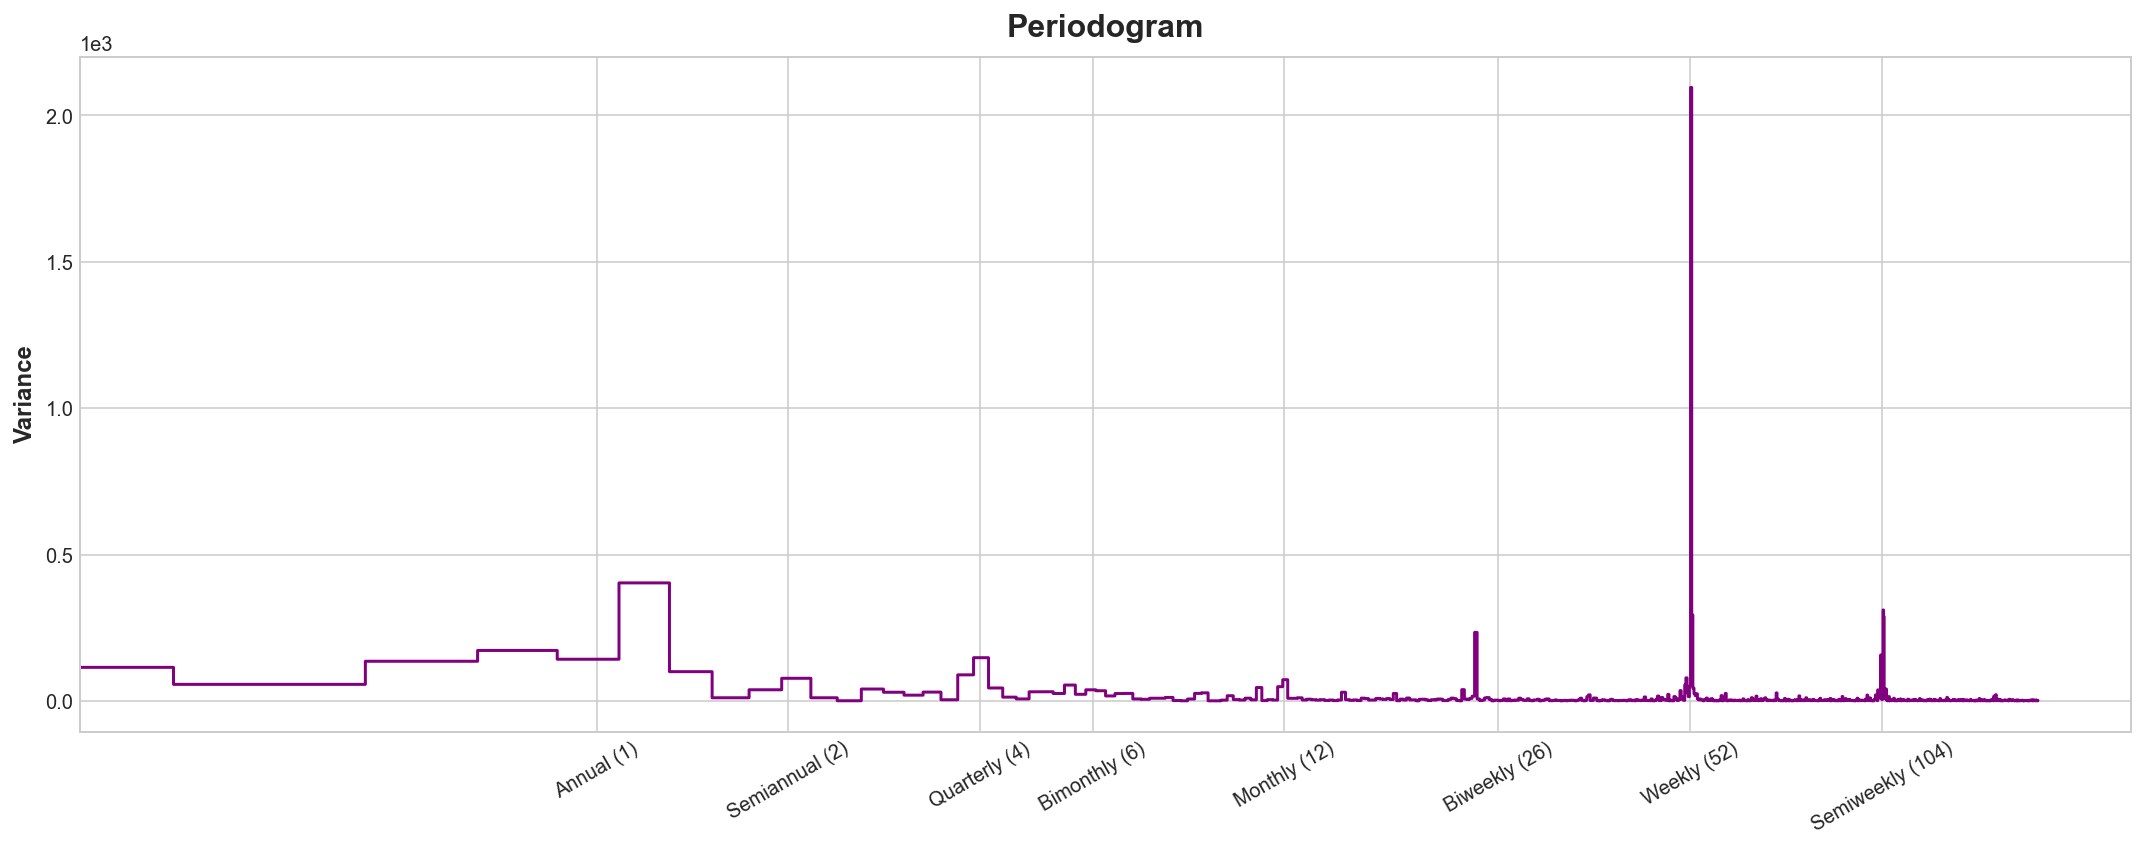

In [10]:
plot_periodogram(avg_daily_stat['sales'])


C:\Users\anton\AppData\Local\Temp\ipykernel_19264\1215223934.py:3: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



<AxesSubplot:xlabel='year', ylabel='sales'>

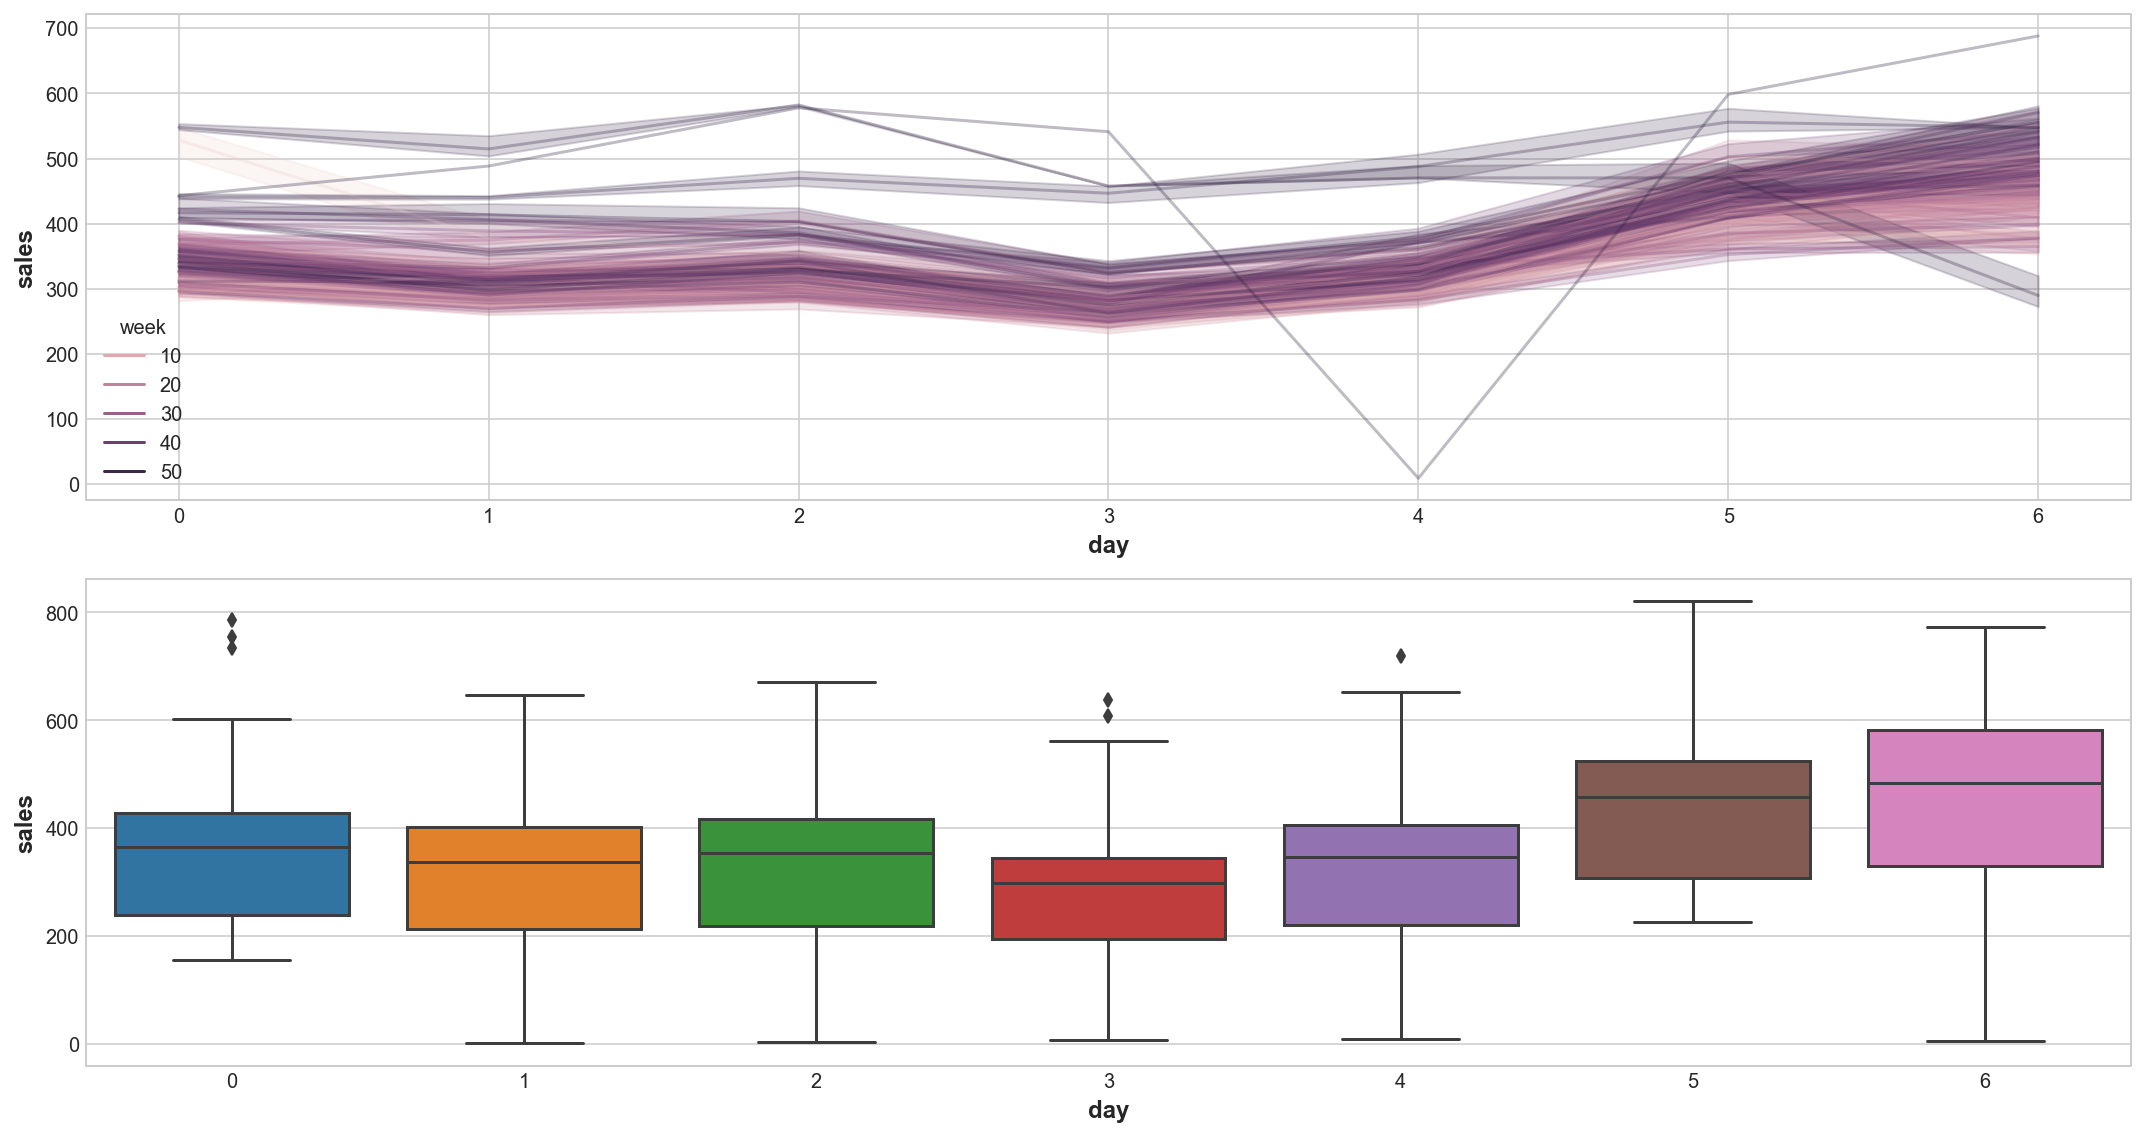

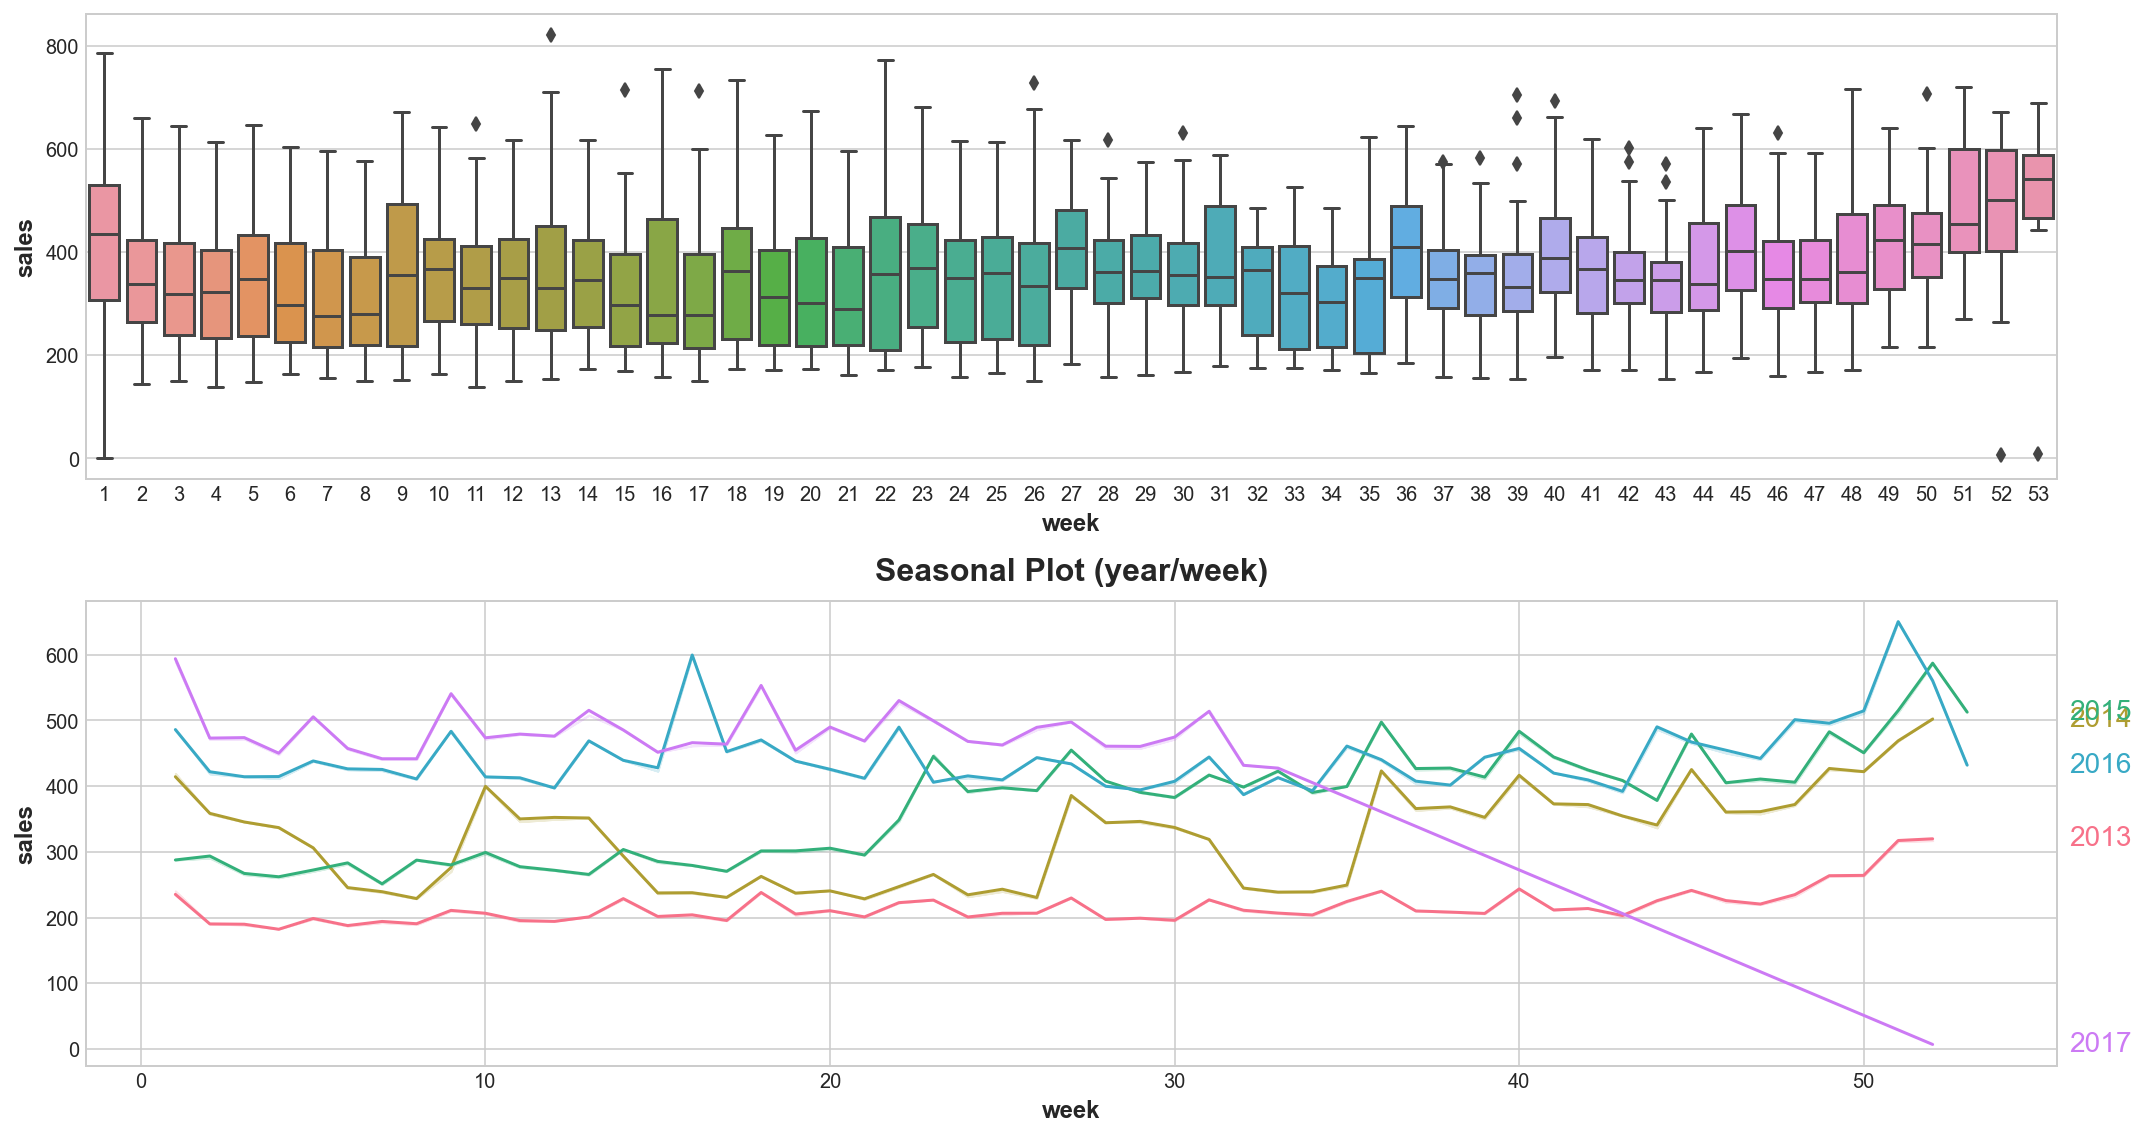

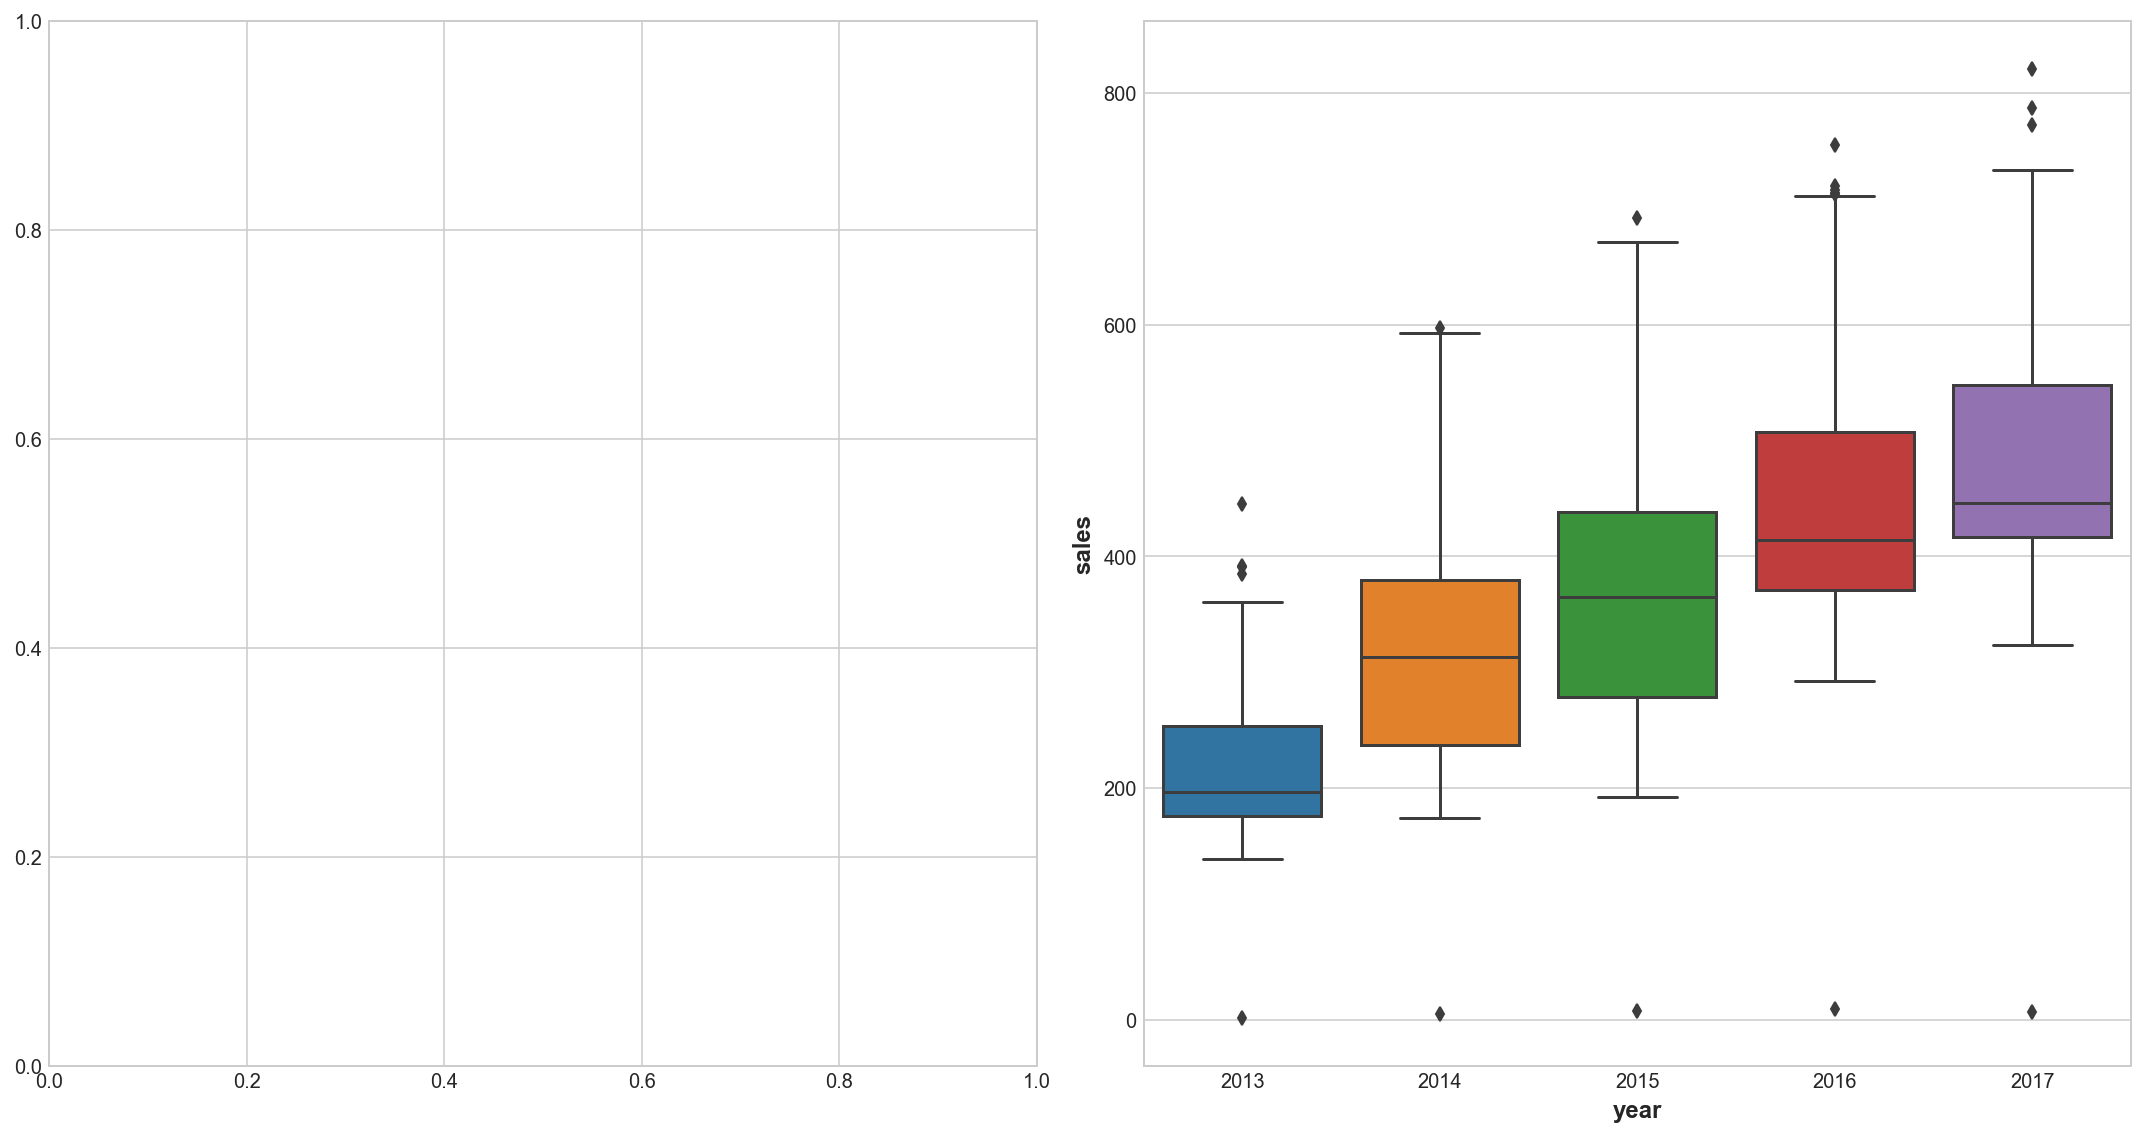

In [109]:
seas_plot = avg_daily_stat.copy()
# week seasonality
seas_plot['week'] = seas_plot.index.weekofyear
seas_plot['day'] = seas_plot.index.dayofweek
seas_plot['dayofyear'] = seas_plot.index.dayofyear
seas_plot['year'] = seas_plot.index.year

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.lineplot(data=seas_plot,x='day',y='sales',hue='week',alpha=0.3,ci=20,ax=ax[0])
sns.boxplot(x=seas_plot['day'],y=seas_plot['sales'],ax=ax[1])
#seasonal_plot(seas_plot, y='sales', period='year', freq='dayofyear', ax=ax[1])

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sns.boxplot(x=seas_plot['week'],y=seas_plot['sales'],ax=ax[0])
seasonal_plot(seas_plot, y='sales', period='year', freq='week', ax=ax[1])

fig, ax = plt.subplots(1,2, figsize=(15, 8))

sns.boxplot(x=seas_plot['year'],y=seas_plot['sales'],ax=ax[1])

In [82]:
seas_plot

,sales,onpromotion,week,day,dayofyear,year
date,,,,,,
2013-01-01,1.409438,0.000000,1,1,1,2013
2013-01-02,278.390807,0.000000,1,2,2,2013
2013-01-03,202.840197,0.000000,1,3,3,2013
2013-01-04,198.911154,0.000000,1,4,4,2013
2013-01-05,267.873244,0.000000,1,5,5,2013
...,...,...,...,...,...,...
2017-08-11,463.733851,7.956790,32,4,223,2017
2017-08-12,444.798280,4.664422,32,5,224,2017
2017-08-13,485.768618,5.209315,32,6,225,2017


In [55]:
pd.options.plotting.backend = "plotly"

<AxesSubplot:title={'center':'Seasonal Plot (week/day)'}, xlabel='day', ylabel='sales'>

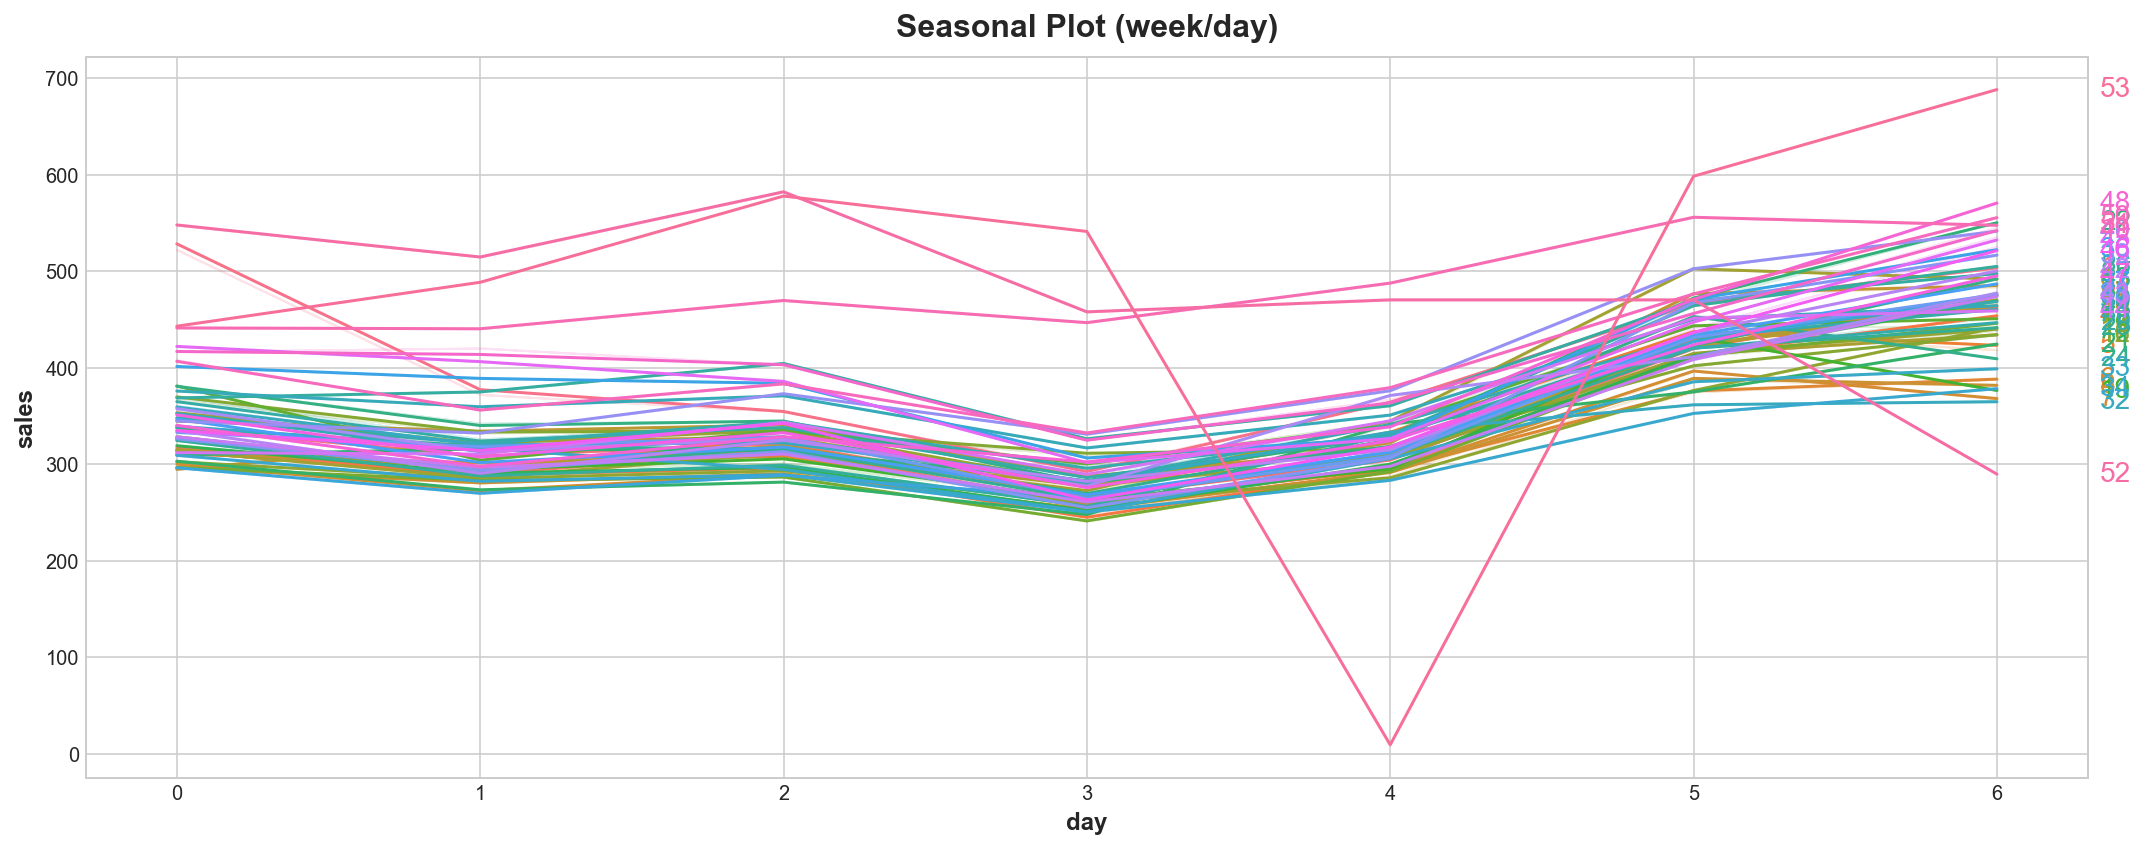

In [79]:
seasonal_plot(seas_plot, y='sales', period='week', freq='day')

There is a little shifting in  year/dayofyear seasonal plot coused by trend, so we can detrend data to see it clearly

In [7]:
# Detrending
dp = DeterministicProcess(index=avg_daily_stat.index,
                          constant=True, 
                          order=3, 
                          drop=True)
# dp=DeterministicProcess(index=avg_daily_stat.index,order=3)
X = dp.in_sample()
y = avg_daily_stat['sales']
# Linear Regr
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
# MARS
# model=Earth()
# model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)


fig = go.Figure(go.Scatter(
                y=avg_daily_stat['sales'],
                x=avg_daily_stat.index,
                name='Avg Daily sales',
                mode='markers',
                marker_color='rgba(150,150,150,1)'),
                layout=layout)

fig.add_trace(go.Scatter(
    y=y_pred,
    x=y_pred.index,
    line={'width': 4, 'color': 'steelblue'}))
fig.update_layout(
    title={'text': 'Regression model'})
fig.show()


In [ ]:
detrend = y-y_pred
moving_avg = detrend.rolling(window=186,
                             min_periods=100,
                             center=True).mean()
# ax = detrend.plot(title='Detrended data')
# moving_avg.plot(ax=ax, color='red', linewidth=3)
fig=go.Figure(go.Scatter(x=detrend.index,y=detrend,name='Daily data'),layout=layout)
fig.add_scatter(
    y=moving_avg,
    x=avg_daily_stat.index,
    line={'width': 4}, name='Moving average'
    )
fig.update_layout(
    yaxis={'title': 'Sales'},
    xaxis={'title': 'Date'},
    title={'text': 'Detrended avg daily stat of sales'}
)
# for holiday_events in pd.merge(holiday,avg_daily_stat,left_index=True,right_index=True).index.unique():
#     fig.add_vline(
#         line_dash='dash',
#         x=holiday_events,
#         line_color='green',
#         line_width=0.5
#     )
fig.show()

### Detrended seasonal plots and periodogram

C:\Users\anton\AppData\Local\Temp\ipykernel_20884\572750137.py:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

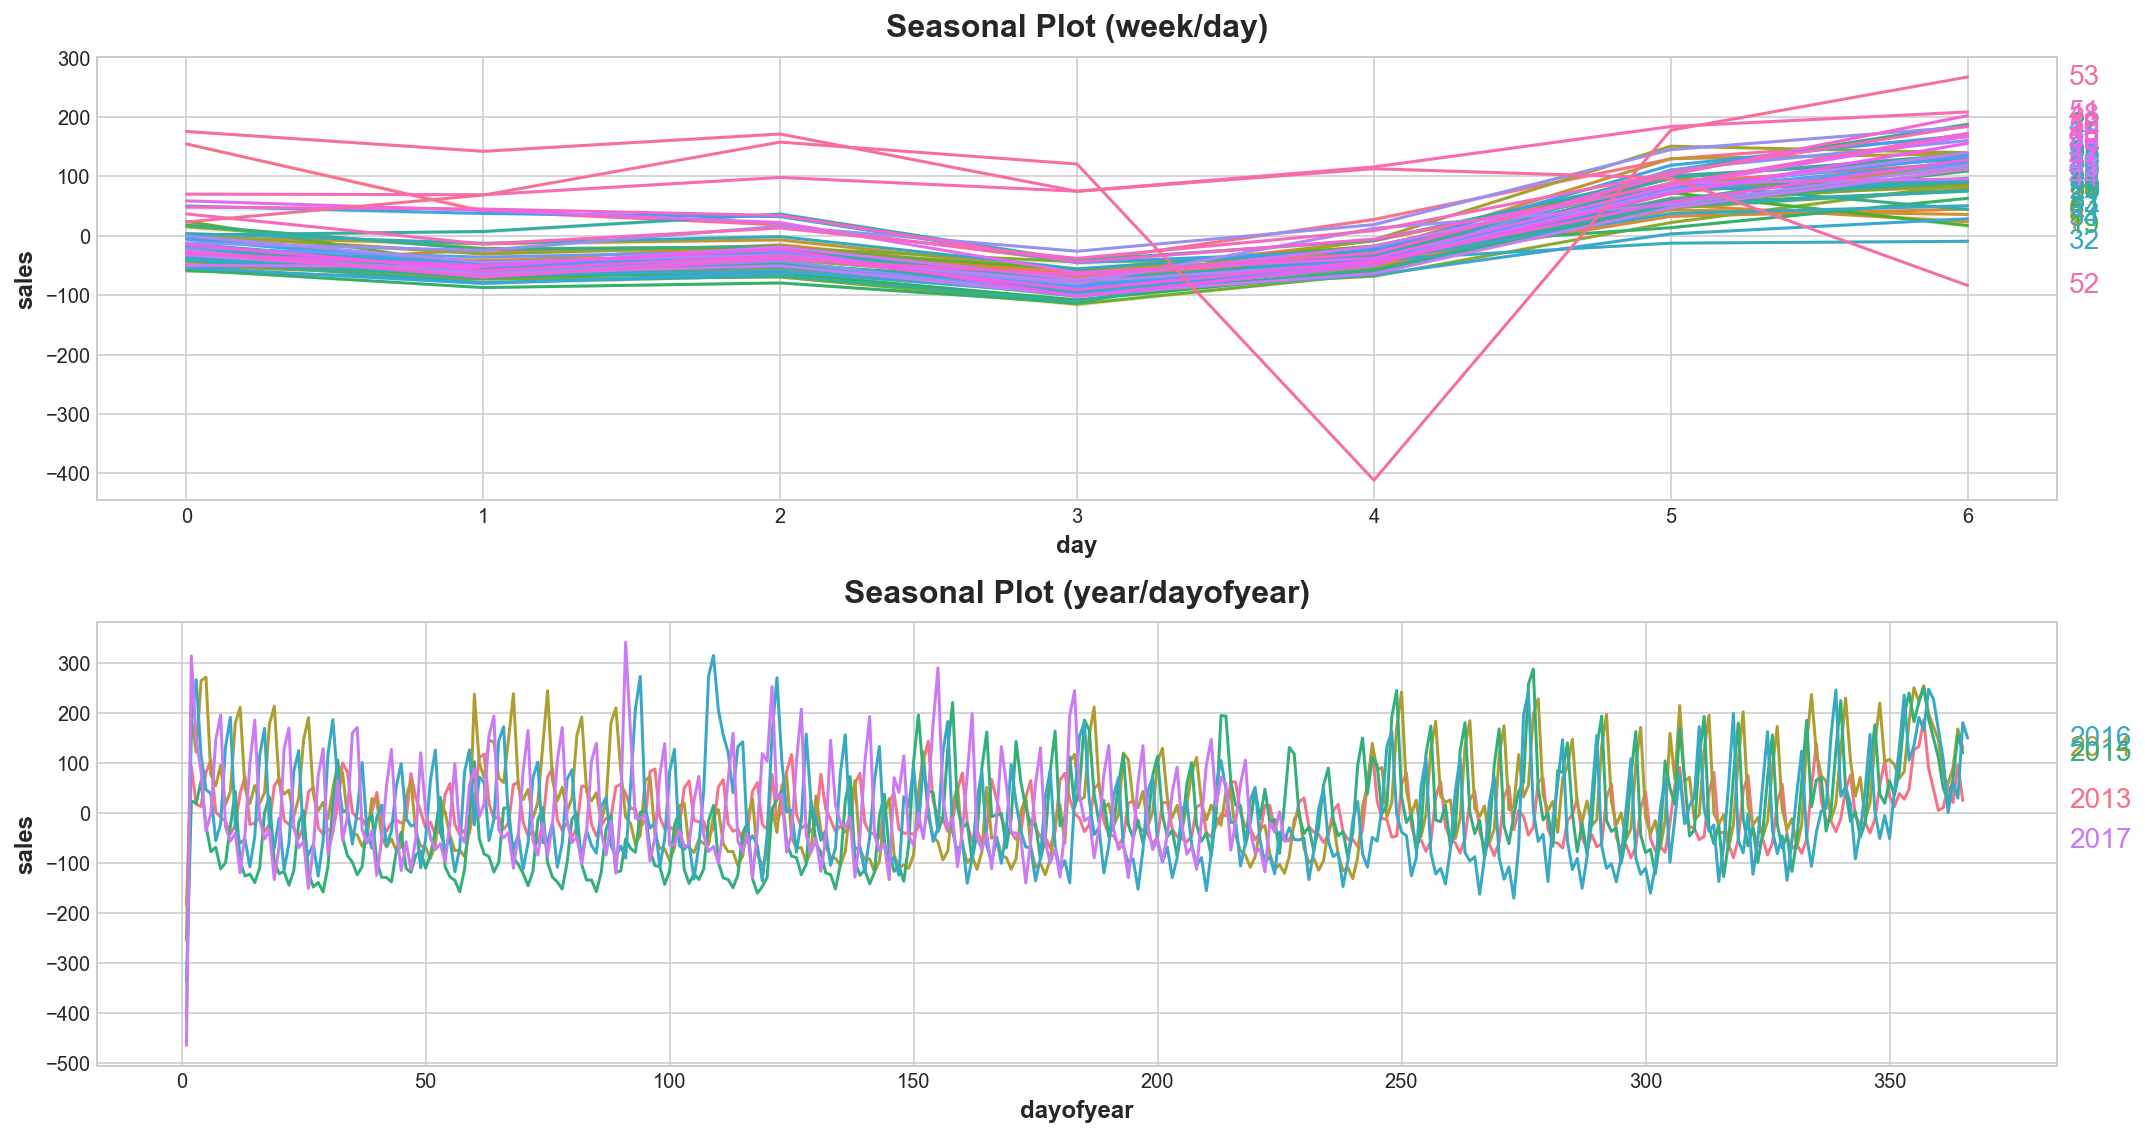

In [ ]:
seas_plot = pd.DataFrame(detrend.copy(), columns=['sales'])

# week seasonality
seas_plot['week'] = seas_plot.index.week
seas_plot['day'] = seas_plot.index.day_of_week
seas_plot['dayofyear'] = seas_plot.index.day_of_year
seas_plot['year'] = seas_plot.index.year
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
seasonal_plot(seas_plot, y='sales', period='week', freq='day', ax=ax[0])
seasonal_plot(seas_plot, y='sales', period='year', freq='dayofyear', ax=ax[1])
# seas_plot


C:\Users\anton\AppData\Local\Temp\ipykernel_20884\2327164487.py:1: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

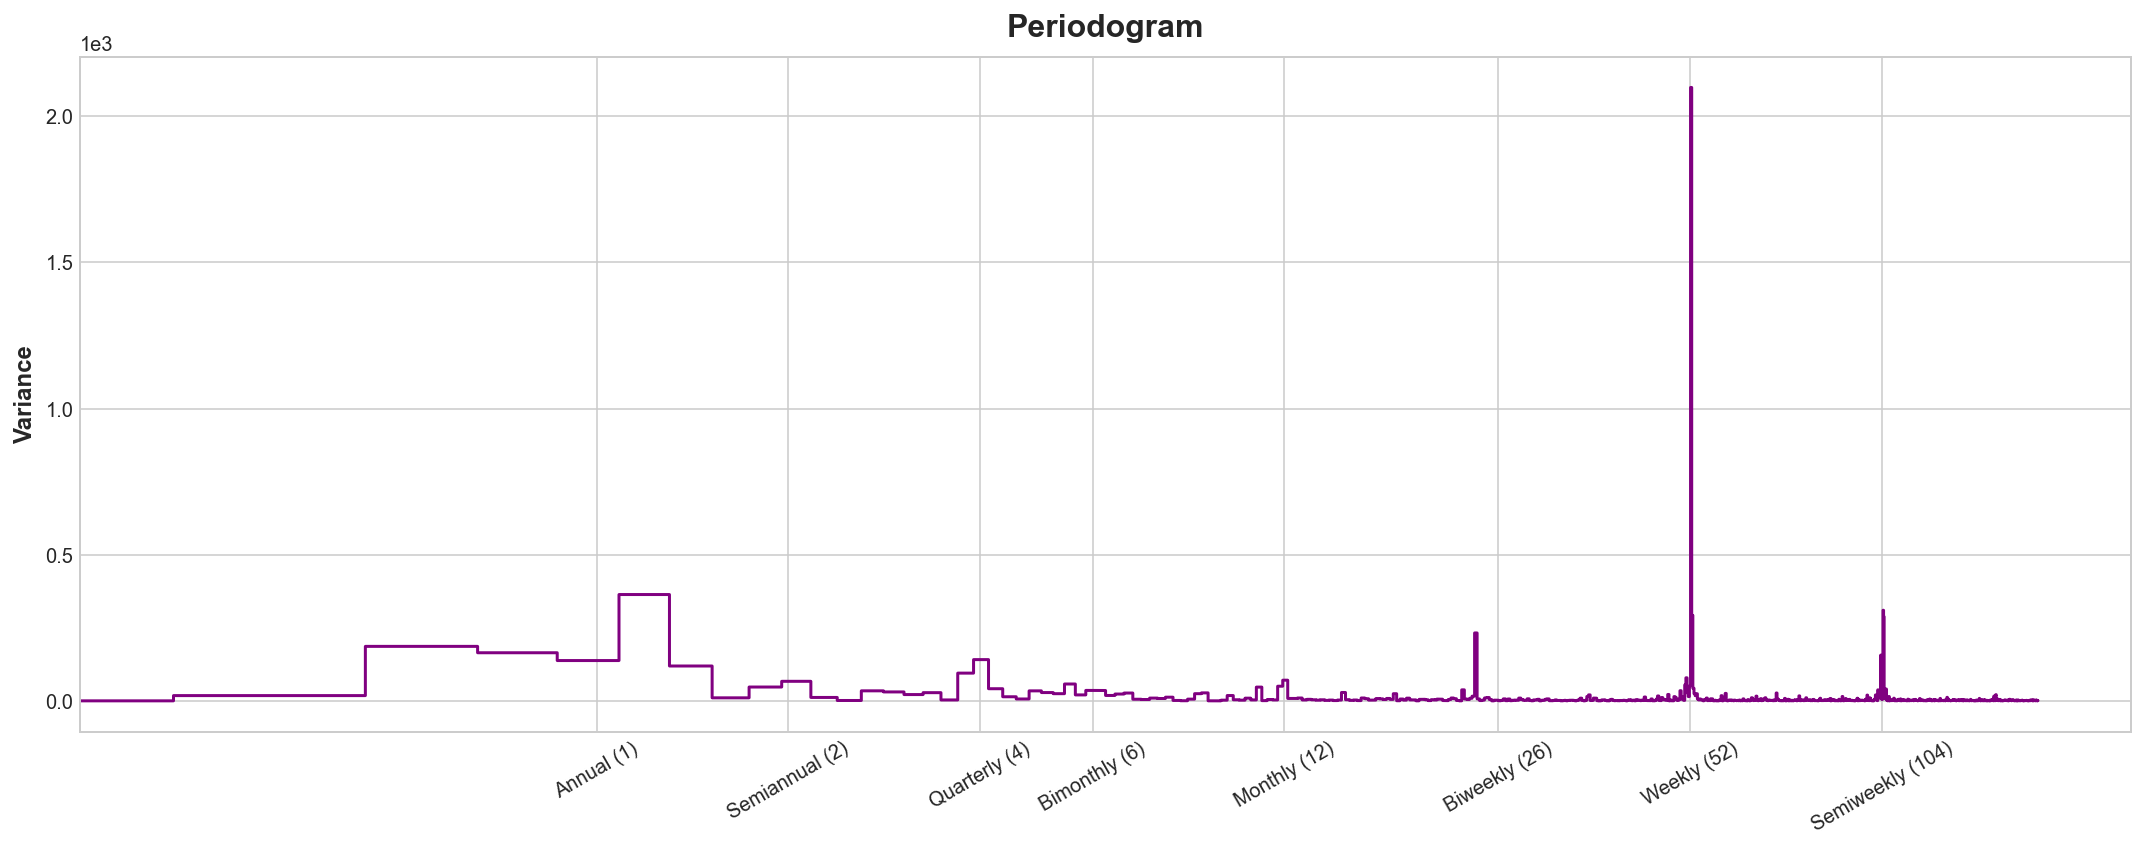

In [ ]:
plot_periodogram(detrend)


## Oil prices

In [13]:
# filling nans using splines

oil.interpolate('spline', order=3, inplace=True)
fig = px.line(oil)
fig.update_layout({'width': 1200,
                   'title': 'Oil Price chart',
                   'yaxis': {'title': 'Price'},
                   'showlegend': False})
fig.show()


In [14]:
sales_oil = oil.copy()
sales_oil = pd.merge(sales_oil, avg_daily_stat.sales,
                     left_index=True, right_index=True)
sales_oil.dropna(inplace=True)


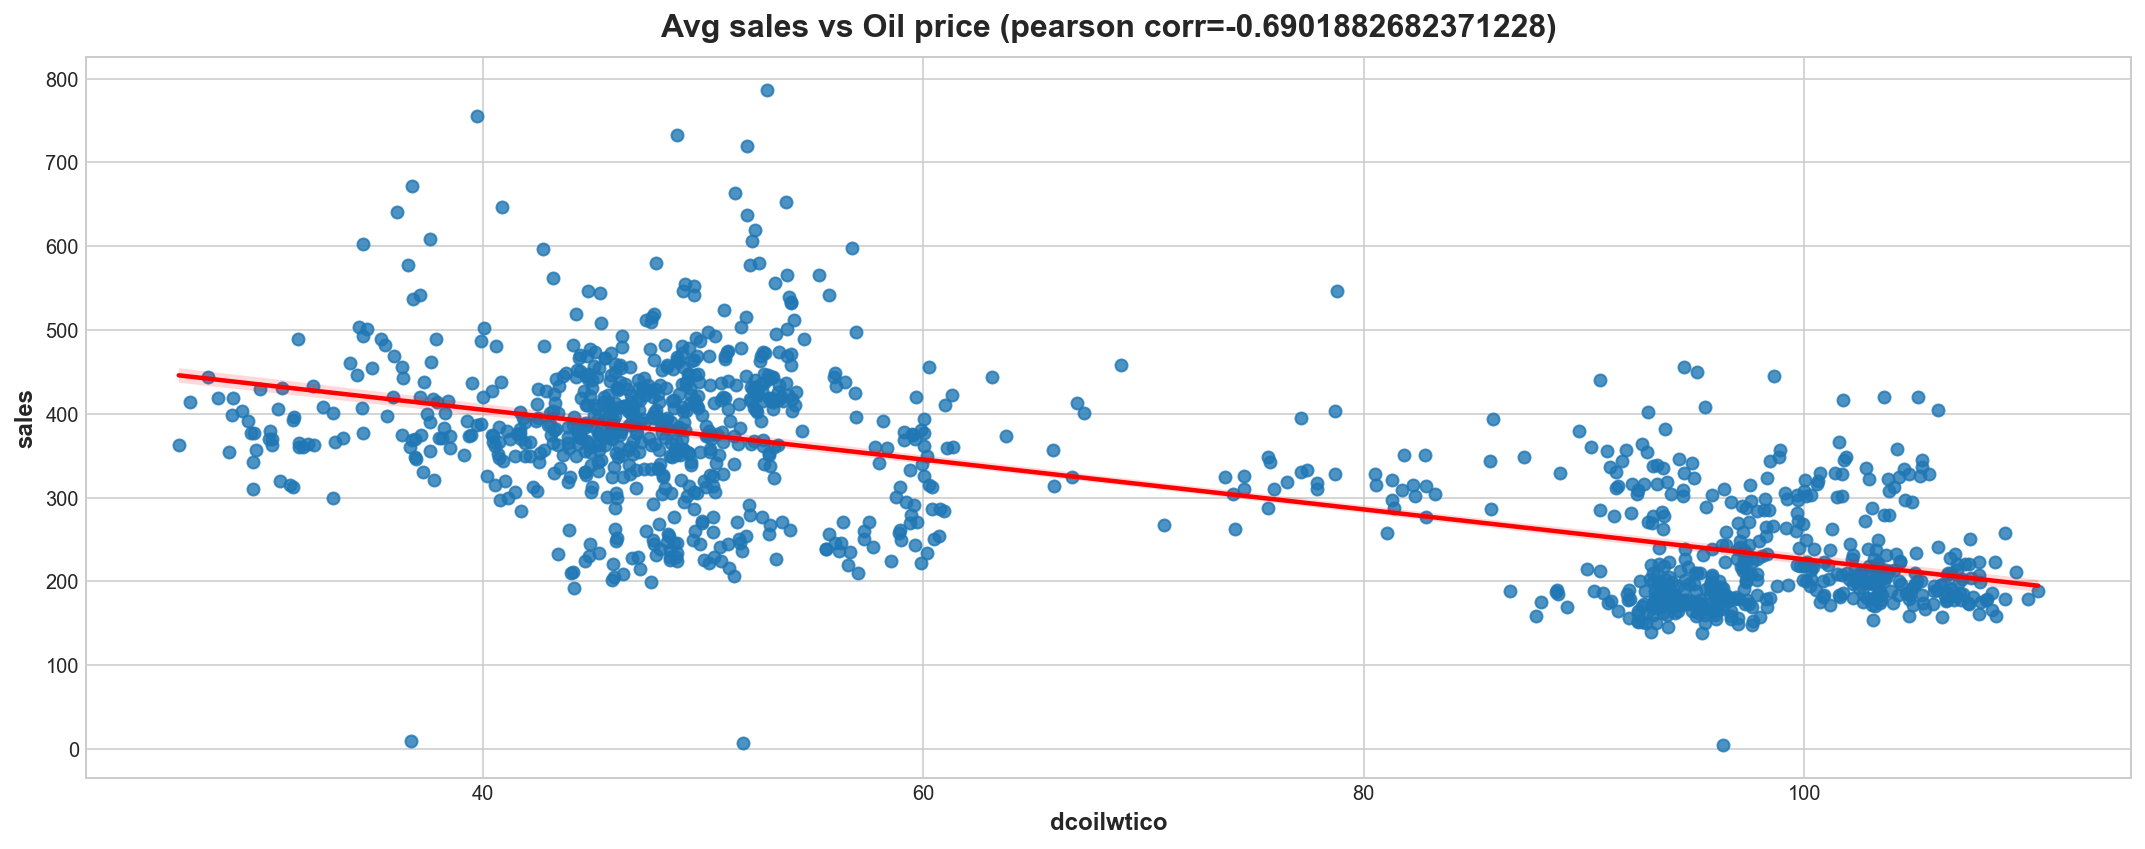

In [15]:
from scipy.stats import pearsonr
corr, _ = pearsonr(sales_oil['sales'], sales_oil['dcoilwtico'])
sns.regplot(data=sales_oil, x='dcoilwtico',
            y='sales', line_kws={'color': 'red'})
plt.title(f'Avg sales vs Oil price (pearson corr={corr})')
plt.show()
